# Part one

In [3]:
# import each library for assignment

import numpy as np
import cmath
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt import solvers

     pcost       dcost       gap    pres   dres
 0: -1.0534e+03 -1.0396e+03  2e+01  9e+00  2e-16
 1: -1.0398e+03 -1.0385e+03  2e+00  8e-01  8e-17
 2: -1.0376e+03 -1.0376e+03  1e-01  4e-02  1e-16
 3: -1.0375e+03 -1.0375e+03  6e-03  2e-16  7e-17
 4: -1.0375e+03 -1.0375e+03  3e-04  2e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5527e-15  3e+02  9e-01  5e-16  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  9e-16  4e-01
 2:  5.8134e+01  5.8186e+01  1e+01  4e-02  3e-14  1e-01
 3:  6.3314e+01  6.3326e+01  2e+00  7e-03  8e-14  2e-02
 4:  6.4289e+01  6.4291e+01  4e-01  1e-03  1e-13  3e-03
 5:  6.4452e+01  6.4452e+01  7e-02  2e-04  6e-14  6e-04
 6:  6.4483e+01  6.4483e+01  3e-03  8e-06  1e-13  2e-05
 7:  6.4484e+01  6.4484e+01  3e-05  8e-08  8e-14  2e-07
Optimal solution found.
[[ 31.24481012]
 [ 28.61614761]
 [ 26.17380801]
 [ 23.90729998]
 [ 21.80655334]
 [ 19.86191023]
 [ 18.06411622]
 [ 16.40431145]
 [ 14.8740218 ]
 [ 13.4651499

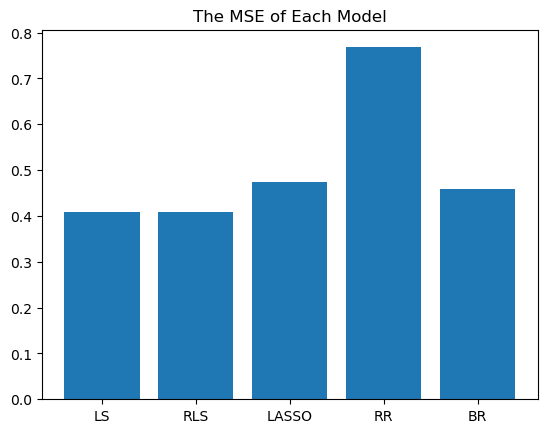

In [42]:
# load and process data


def data_processing():

    sample_X = np.loadtxt('./PA-1-data-text/polydata_data_sampx.txt')
    sample_Y = np.loadtxt('./PA-1-data-text/polydata_data_sampy.txt')
    poly_X = np.loadtxt('./PA-1-data-text/polydata_data_polyx.txt')
    poly_Y = np.loadtxt('./PA-1-data-text/polydata_data_polyy.txt')

    true_theta = np.loadtxt('./PA-1-data-text/polydata_data_thtrue.txt')

    sample_X = sample_X.reshape(1, len(sample_X))
    sample_Y = sample_Y.reshape(len(sample_Y), 1)

    poly_X = poly_X.reshape(1, len(poly_X))
    poly_Y = poly_Y.reshape(len(poly_Y), 1)

    return sample_X, sample_Y, poly_X, poly_Y

# generate Phi(x).
def generate_Phix(X, K):
    return np.array( [ X**k for k in range(K+1)]).reshape(K+1, 1)

# generate Big Phi matrix dimen is (K, N).
def generate_Phi_mat(Sample, K):
    return np.array( [generate_Phix(x, K) for x in Sample[0]])[:,:, (Sample.shape[0]-1)].T

# Do the prediction though the fixed Theta.
def pred_polyY(polyX, Theta):
    # Theta dim: (K+1, 1)
    Phi_mat_T = generate_Phi_mat(polyX, Theta.shape[0]-1).T
    pred_Y = np.dot(Phi_mat_T, Theta)
    return pred_Y

def least_squares_Theta(SampleX, SampleY, K):
    Phi_mat = generate_Phi_mat(Sample=SampleX, K=K)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T)), np.dot(Phi_mat, SampleY))
    return Theta

def Regular_LS_Theta(SampleX, SampleY, K, lbda=0.1):
    Phi_mat = generate_Phi_mat(Sample=SampleX, K=K)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T) + lbda * np.ones((K+1, K+1))), np.dot(Phi_mat, SampleY))
    return Theta

def L1_LS_Theta(SampleX, SampleY, K, lbda=1):
    # refer to the Problem Set 3.12
    # To solve Lasso, construct the matrix: 
    # X dimen:(2(K+1), 1), H dimen:(2(K+1), 2(K+1)), f dimen:(2(K+1), 1), G and h based on constraint dimen: (2(K+1), 2(K+1)), h (2(K+1) 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K)
    Phi_square = np.dot(Phi_mat, Phi_mat.T)
    Phi_y = np.dot(Phi_mat, SampleY)
    H_left = np.concatenate((Phi_square, -Phi_square), axis=0)
    H = np.concatenate( (H_left, -H_left), axis=1 )
    f = lbda*np.ones((H.shape[0], 1)) - np.concatenate( (Phi_y, -Phi_y), axis=0 )
    G = - np.identity(H.shape[0])
    h = np.zeros( (H.shape[0], 1) )
    Lasso_theta = solvers.qp(P=matrix(H), q=matrix(f), G=matrix(G), h=matrix(h))['x']
    Lasso_theta = np.matrix(Lasso_theta)
    # Lasso_theta is  [theta+, theta-]T, to get the theta = theta+ - theta-
    Theta = Lasso_theta[: int(H.shape[0]/2)] - Lasso_theta[ int(H.shape[0]/2):]
    Theta = np.matrix(Theta)
    return Theta
    
def Robust_LS(SampleX, SampleY, K):
     # refer to the Problem Set 2.10
    # To solve Robust, construct the matrix: 
    # X dimen:((K+1) + N, 1), f dimen:((K+1) + N, 1), , A and b based on constraint dimen:(2N, (K+1) + N), b (2N， 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K)
    f = np.concatenate((np.zeros((Phi_mat.shape[0], 1)), np.ones((SampleX.shape[1],1))), axis=0)
    A_left = np.concatenate( (-Phi_mat.T, Phi_mat.T), axis=0 )
    A_right = np.concatenate( (-np.identity(SampleX.shape[1]), -np.identity(SampleX.shape[1])), axis=0)
    A = np.concatenate( (A_left, A_right), axis=1 )
    b = np.concatenate((-SampleY, SampleY))
    Robust_theta = solvers.lp(G=matrix(A),c=matrix(f), h=matrix(b))['x']
    Theta = np.matrix(Robust_theta[: K+1])
    return Theta

def Bayes_post(SampleX, SampleY, sigma_square, K):
    Phi_mat = generate_Phi_mat(SampleX, K)
    alpha = 1
    Cov_mat = np.linalg.inv((1/alpha * np.identity((Phi_mat.shape[0])) + 1/sigma_square * np.dot(Phi_mat, Phi_mat.T)))
    Mu_theta = 1/(sigma_square)* np.dot(Cov_mat, np.dot(Phi_mat, SampleY) )
    return Mu_theta, Cov_mat

def Bayes_pred(Mu, Cov, PolyX):
    # Mu dim (K+1, 1)
    Phi_mat = generate_Phi_mat(PolyX, Mu.shape[0]-1)
    pred = np.dot(Phi_mat.T, Mu)
    pred_var = np.dot(Phi_mat.T, np.dot(Cov, Phi_mat))
    std_var = np.sqrt(pred.diagonal())
    return pred, std_var

# def hyperpara()

def MSE(pred, true):
    # L2 is sqrt(y1^2 + y2^2 .... yn^2)
    print(pred)
    return np.linalg.norm(true-pred, ord=2)**2/len(pred)

def MAE(pred, true):
    return np.linalg.norm(true-pred, ord=1)/len(pred)

def plot_MSE(MSE_model):
    plt.title('The MSE of Each Model')
    plt.bar(MSE_model.keys(), MSE_model.values())
    plt.show()

def plot_each_model(samplex, sampley, X, pred, Y):
    
    plt.scatter(samplex[0], sampley, label='Samples')
    plt.plot(X[0], pred, 'b-', label='Prediction Value')
    plt.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()
    plt.show()

x, y, b, d = data_processing()

ls_theta = least_squares_Theta(x, y, 5)
Regular_theta = Regular_LS_Theta(x, y, 5)
L1_theta = L1_LS_Theta(x, y, 5)
Robust_theta = Robust_LS(x, y, 5)
Mu_theta, cov_theta = Bayes_post(x,y,5,5)

pred_ls = pred_polyY(b, ls_theta)
pred_Regular = pred_polyY(b, Regular_theta)
pred_L1 = pred_polyY(b, L1_theta)
pred_Robust = pred_polyY(b, Robust_theta)
pred_bayes, std_var = Bayes_pred(Mu_theta, cov_theta, b)

model_dict = {'LS': MSE(pred_ls, d), 'RLS': MSE(pred_Regular, d), 
'LASSO': MSE(pred_L1, d), 'RR': MSE(pred_Robust, d), 'BR': MSE(pred_bayes, d)}
plot_MSE(model_dict)
# mu,cov = Bayes_post(x,y,sigma=5,K=5)
# pred, std = Bayes_pred(mu,cov, b)
